# Code for data analysis - Stern Gerlach

In [9]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

### Reading data and loading list

Read the output files and save the average trajectories.

Each output file refer to a point in phase-space, and it is labelled in (q,p).

Iside each file, we store:

- u0 : population of ground state
- u1 : population of first excited state
- coher : coherence

In [8]:
# For this example we already know the points in phase space to consider!
pos = [0.0]
mom = [-0.1,0.0,0.1]

phasespace = []

for q in pos:
    for p in mom:
        
        filename = './output/average_trajectory_pos_{0}_mom_{1}.dat'.format( str(q) , str(p) )
        Qtrajectory = np.loadtxt(filename,
                                 skiprows = 4,
                                 delimiter = ' , ',
                                 usecols = (0,1),
                                 dtype = np.float
                                 )
        point_phasespace = {'pos' : q , 'mom' : p , 'populations' : Qtrajectory}
        phasespace.append(point_phasespace)

### Plot the evolution

We now plot the population on the different point in phase-space

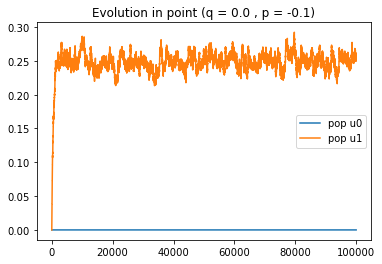

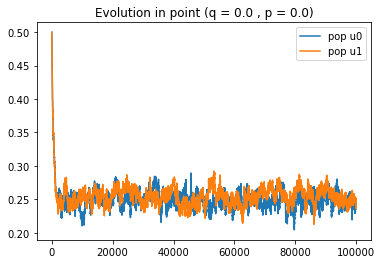

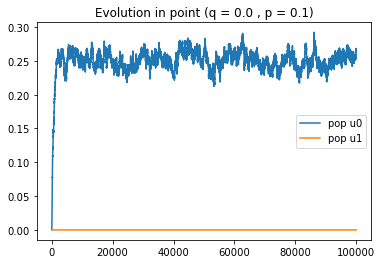

In [33]:
for point in phasespace:
    q = point['pos']
    p = point['mom']
    u0 = point['populations'][:,0]
    u1 = point['populations'][:,1]
    tit = 'Evolution in point (q = {0} , p = {1})'.format( str(q), str(p) )

    evo_u0, = plt.plot(u0, label='pop u0')
    evo_u1, = plt.plot(u1, label='pop u1')
    plt.legend(handles=[evo_u0, evo_u1])
    plt.title(tit)
    plt.show()